# Resnet18

In [2]:
import torch
import torchvision

from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from torch import nn, optim

import matplotlib.pyplot as plt
from devinterp.slt.sampler import estimate_rlct

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('mps')

In [11]:
# Transform to imagenet format
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.244, 0.225]
    )
])

trainset = datasets.CIFAR10(root='../data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='../data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=256, shuffle=True)
testloader = DataLoader(testset, batch_size=256, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [12]:
from tqdm.notebook import trange, tqdm

model = torchvision.models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 10)
model = model.to(device)

def finetune(model, trainloader, testloader, lr=0.01, momentum=0.9, epochs=None, epsilon=1e-4, weight_decay=0.):
    opt = optim.SGD(model.fc.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    loss_fn = nn.CrossEntropyLoss()
    
    train_loss_history = []
    test_loss_history = []
    train_acc_history = []
    test_acc_history = []
    
    epoch = 0
    prev_train_loss = float('inf')
    
    while True:
        # Train
        model.train()
        epoch_loss = 0.0
        for x, y in tqdm(trainloader, desc=f"Epoch {epoch}", leave=False):
            x, y = x.to(device), y.to(device)
            opt.zero_grad()
            loss = loss_fn(model(x), y)
            loss.backward()
            opt.step()
            epoch_loss += loss.item()
        
        # Eval on training set
        model.eval()
        with torch.no_grad():
            total_train_loss = 0
            total_train_correct = 0

            for x, y in trainloader:
                x, y = x.to(device), y.to(device)
                output = model(x)

                # print(x.shape, y.shape, output.shape)
                loss = loss_fn(output, y)
                total_train_loss += loss.item()
                total_train_correct += (output.argmax(dim=1) == y).sum().item()

            avg_train_loss = total_train_loss / len(trainloader)
            avg_train_acc = total_train_correct / len(trainset)
            train_loss_history.append(avg_train_loss)
            train_acc_history.append(avg_train_acc)
            
            # Eval on test set
            total_test_loss = 0
            total_test_correct = 0

            for x, y in testloader:
                x, y = x.to(device), y.to(device)
                output = model(x)
                loss = loss_fn(output, y)
                total_test_loss += loss.item()
                total_test_correct += (output.argmax(dim=1) == y).sum().item()
            
            avg_test_loss = total_test_loss / len(testloader)
            avg_test_acc = total_test_correct / len(testset)
            test_loss_history.append(avg_test_loss)
            test_acc_history.append(avg_test_acc)
        
            print(f"Epoch: {epoch}, Train Loss: {avg_train_loss}, Test Loss: {avg_test_loss}, Train Acc: {avg_train_acc}, Test Acc: {avg_test_acc}")
        
        # Check for convergence
        if epsilon and abs(prev_train_loss - avg_train_loss) < epsilon:
            break
        
        if epochs is not None and epoch >= epochs - 1:
            break
        
        prev_train_loss = avg_train_loss
        epoch += 1
    
    # Plotting
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(test_loss_history, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.legend()
    plt.show()

    plt.plot(train_acc_history, label='Train Acc')
    plt.plot(test_acc_history, label='Test Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

finetune(model, trainloader, testloader, lr=0.001, weight_decay=0.1, epsilon=0.001)

/Users/Jesse/Projects/devinterp/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/Jesse/Projects/devinterp/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0:   0%|          | 0/196 [00:00<?, ?it/s]

torch.Size([256, 3, 224, 224]) torch.Size([256]) torch.Size([256, 10])
torch.Size([256, 3, 224, 224]) torch.Size([256]) torch.Size([256, 10])
torch.Size([256, 3, 224, 224]) torch.Size([256]) torch.Size([256, 10])
torch.Size([256, 3, 224, 224]) torch.Size([256]) torch.Size([256, 10])
torch.Size([256, 3, 224, 224]) torch.Size([256]) torch.Size([256, 10])
torch.Size([256, 3, 224, 224]) torch.Size([256]) torch.Size([256, 10])
torch.Size([256, 3, 224, 224]) torch.Size([256]) torch.Size([256, 10])
torch.Size([256, 3, 224, 224]) torch.Size([256]) torch.Size([256, 10])
torch.Size([256, 3, 224, 224]) torch.Size([256]) torch.Size([256, 10])
torch.Size([256, 3, 224, 224]) torch.Size([256]) torch.Size([256, 10])
torch.Size([256, 3, 224, 224]) torch.Size([256]) torch.Size([256, 10])
torch.Size([256, 3, 224, 224]) torch.Size([256]) torch.Size([256, 10])
torch.Size([256, 3, 224, 224]) torch.Size([256]) torch.Size([256, 10])
torch.Size([256, 3, 224, 224]) torch.Size([256]) torch.Size([256, 10])
torch.

Epoch 1:   0%|          | 0/196 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [6]:
for i in range(10):
    rlct = estimate_rlct(model, dataloader, nn.CrossEntropyLoss(), step='sgld', num_draws=10, num_chains=5, num_burnin_steps=0, num_steps_bw_draws=1, cores=None, seed=None, pbar=True, baseline='init', device=device)
    print(f"Estimate {i}:", rlct)

Chain 4: 100%|██████████| 10/10 [00:00<00:00, 15.91it/s]


Estimate 0: 20618.3155769216


Chain 4: 100%|██████████| 10/10 [00:00<00:00, 15.92it/s]


Estimate 1: 20670.238494501522


Chain 4: 100%|██████████| 10/10 [00:00<00:00, 16.09it/s]


Estimate 2: 20496.632707999845


Chain 4: 100%|██████████| 10/10 [00:00<00:00, 16.41it/s]


Estimate 3: 20708.223293329367


Chain 4: 100%|██████████| 10/10 [00:00<00:00, 15.72it/s]


Estimate 4: 21139.081171217716


Chain 4: 100%|██████████| 10/10 [00:00<00:00, 14.92it/s]


Estimate 5: 21799.607447388487


Chain 4: 100%|██████████| 10/10 [00:00<00:00, 15.91it/s]


Estimate 6: 21293.165070258412


Chain 4: 100%|██████████| 10/10 [00:00<00:00, 16.47it/s]


Estimate 7: 21638.908227683212


Chain 4: 100%|██████████| 10/10 [00:00<00:00, 14.49it/s]


Estimate 8: 21204.354273595836


Chain 4: 100%|██████████| 10/10 [00:00<00:00, 16.21it/s]

Estimate 9: 21375.215056744957


In [9]:
import os

rlcts = []
resnet_depths = [18, 34, 50, 101, 152]

for num_layers in resnet_depths:
    print("-" * 20 + f" ResNet{num_layers} " + "-" * 20)
    model_name = f"resnet{num_layers}"
    model = getattr(torchvision.models, model_name)(pretrained=True).to(device)

    checkpoint_name = f"../checkpoints/resnet-finetuned-cifar/{model_name}.pt"
    
    if os.path.exists(checkpoint_name):
        print("Loading from checkpoint")
        model.load_state_dict(torch.load(checkpoint_name))
    else:
        finetune(model)
        torch.save(model.state_dict(), checkpoint_name)

    _rlcts = []

    for i in range(3):
        _rlct = estimate_rlct(model, dataloader, nn.CrossEntropyLoss(), step='sgld', num_draws=100, num_chains=3, num_burnin_steps=0, num_steps_bw_draws=1, optimizer_kwargs={"elasticity": 100}, cores=None, seed=None, pbar=True, baseline='init', device=device)
        _rlcts.append(_rlct)
        print(_rlct)

    rlcts.append(_rlcts)


-------------------- ResNet18 --------------------


/Users/Jesse/Projects/devinterp/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading from checkpoint


Chain 2: 100%|██████████| 100/100 [00:07<00:00, 13.84it/s]


27880.18221959393


Chain 2: 100%|██████████| 100/100 [00:07<00:00, 13.92it/s]


29073.924645010513


Chain 2: 100%|██████████| 100/100 [00:07<00:00, 13.89it/s]
/Users/Jesse/Projects/devinterp/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/Jesse/Projects/devinterp/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


27904.688433399522
-------------------- ResNet34 --------------------
Loading from checkpoint


Chain 2: 100%|██████████| 100/100 [00:11<00:00,  8.82it/s]


23122.454215606544


Chain 2: 100%|██████████| 100/100 [00:10<00:00,  9.42it/s]


23460.14748207692


Chain 2: 100%|██████████| 100/100 [00:10<00:00,  9.26it/s]
/Users/Jesse/Projects/devinterp/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/Jesse/Projects/devinterp/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


23565.34652797531
-------------------- ResNet50 --------------------
Loading from checkpoint


Chain 2: 100%|██████████| 100/100 [00:17<00:00,  5.76it/s]


24445.212702964436


Chain 2: 100%|██████████| 100/100 [00:17<00:00,  5.64it/s]


24496.579451165526


Chain 2: 100%|██████████| 100/100 [00:18<00:00,  5.36it/s]
/Users/Jesse/Projects/devinterp/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/Jesse/Projects/devinterp/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


23823.437147975714
-------------------- ResNet101 --------------------
Loading from checkpoint


Chain 2: 100%|██████████| 100/100 [00:29<00:00,  3.38it/s]


14748.063076120457


Chain 2: 100%|██████████| 100/100 [00:29<00:00,  3.44it/s]


14579.129788372586


Chain 2: 100%|██████████| 100/100 [00:29<00:00,  3.40it/s]
/Users/Jesse/Projects/devinterp/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/Jesse/Projects/devinterp/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


15513.548725992572
-------------------- ResNet152 --------------------


Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /Users/Jesse/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


URLError: <urlopen error [Errno 8] nodename nor servname provided, or not known>

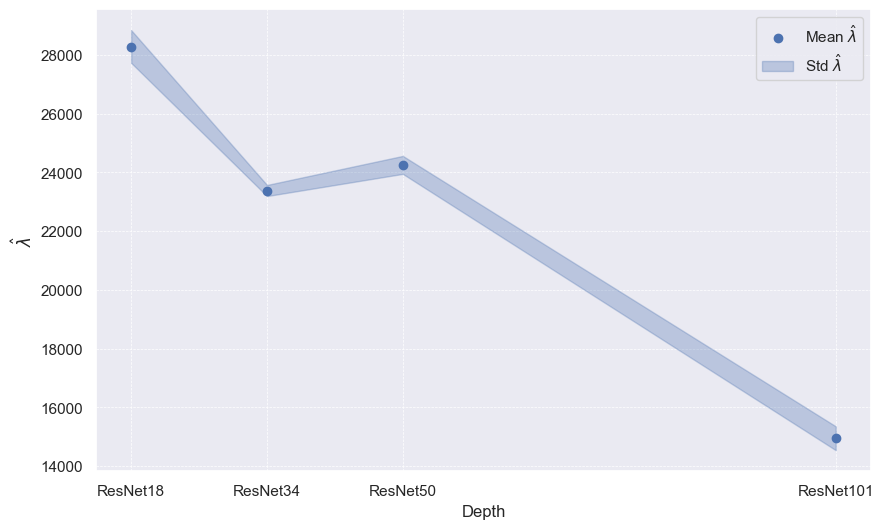

: 

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set()

blue = sns.color_palette()[0]

resnet_depths = [18, 34, 50, 101]

# Names for the different ResNet architectures
arch_names = ["ResNet18", "ResNet34", "ResNet50", "ResNet101"] #, "ResNet152"]

# Calculate means and standard deviations
means = [np.mean(_rlcts) for _rlcts in rlcts]
stds = [np.std(_rlcts) for _rlcts in rlcts]

# Calculate error bounds
lower_bounds = [mean - std for mean, std in zip(means, stds)]
upper_bounds = [mean + std for mean, std in zip(means, stds)]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the scatter points for the means
plt.scatter(resnet_depths, means, color=blue, label=r'Mean $\hat\lambda$', zorder=2)

# Plot the transparent area chart for the error bars
plt.fill_between(resnet_depths, lower_bounds, upper_bounds, color=blue, alpha=0.3, label=r'Std $\hat\lambda$')

# Annotate and style the plot
plt.xlabel('Depth')
plt.ylabel(r'$\hat\lambda$')
plt.xticks(resnet_depths, arch_names)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()

# Show the plot
plt.show()
